In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("../ELPH/")
import PHELPH


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
system = PHELPH.PHELPH(kmax=2.5, n_kmax=100)

../ELPH/ELPH.py:115: RuntimeWarning: invalid value encountered in sqrt
  helper1 = np.sqrt(x*x+self.get_k(dk,n_k)*self.get_k(dk,n_k) - 2.*x*self.get_k(dk,n_k)*np.cos(phi_diff) + 1e-15)


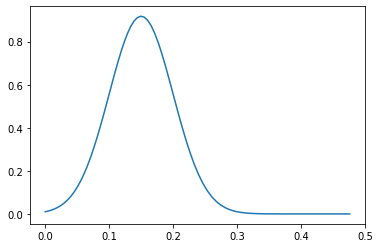

In [3]:
inits = system.get_init_cond_gauss(max_pos = 0.15, width = 0.05, density=0.12, I_0=1e-6)

plt.plot(system.E_el_vec,inits[:system.n_kmax])
plt.show()

In [4]:
#smooth
system.g_photon = 0.02
system.tau_photon = 200
system.E_photon = 0.02
system.linewidth = 0.005

system.setup_laser()

In [5]:
tmax=10000
n_tmax = 1001
t_vec = np.linspace(0,tmax,n_tmax)

trajectory = system.get_full_trajectory(inits, tmax=tmax, n_tmax=n_tmax)

el_trajectory = trajectory[:,:system.n_kmax]

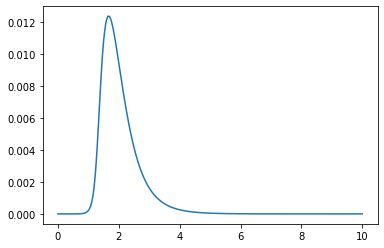

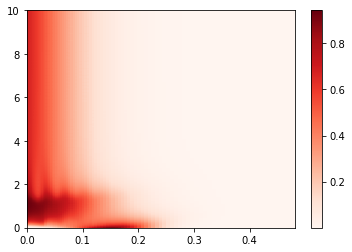

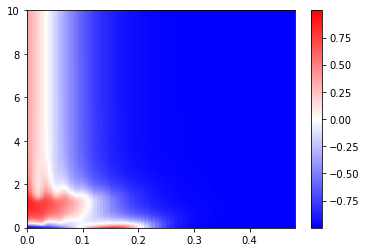

In [6]:
plt.plot(t_vec/1000,trajectory[:,-1])
plt.show()

import matplotlib.colors as colors

plt.pcolormesh(system.E_el_vec, t_vec/1000, el_trajectory,cmap='Reds')
plt.colorbar()
plt.show()


inversion = 2*el_trajectory - 1.

plt.pcolormesh(system.E_el_vec, t_vec/1000, inversion,
           cmap='bwr',
           norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

In [7]:
sys.path.append("../utils/")
import fermi_fit

fermi_fitter = fermi_fit.fermi_fit(system.DOS_vec,system.E_el_vec,system.kB)


In [8]:
tau_rel = 500

def derivs(t,y):
    el_state = y[:-1]
    I = y[-1]
    
    
    mu = mu,steps = fermi_fitter.fit_mu(el_state, 0.1, system.T_cryo, False)
    fermi = fermi_fitter.fermi(system.E_el_vec,mu,system.T_cryo)
    
    df = (fermi - el_state)/tau_rel
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)
    
    
    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9
    
    return np.concatenate((df,[dI]))
    

In [9]:
from scipy.integrate import solve_ivp as scpy_solve_ivp

rta_inits = np.concatenate((inits[:system.n_kmax],[inits[-1]]))

tmax = 10000
n_tmax = 1001

t_vec = np.linspace(0.0, tmax, n_tmax)
sol = scpy_solve_ivp(derivs, [t_vec[0],t_vec[-1]], rta_inits, t_eval=t_vec)

#y_values = np.reshape(np.asarray(sol.y).T,(n_tmax,5,self.n_kmax))
#return y_values[:,:,:]

rta_trajectory =  sol.y.T


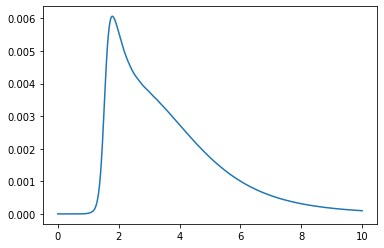

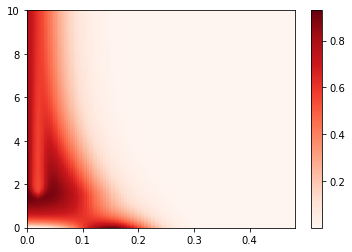

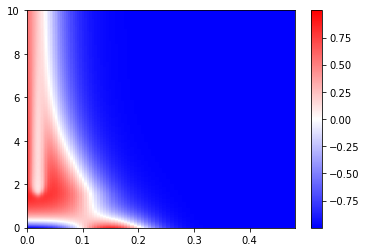

In [10]:
plt.plot(t_vec/1000,rta_trajectory[:,-1])
plt.show()

plt.pcolormesh(system.E_el_vec, t_vec/1000, rta_trajectory[:,:-1],cmap='Reds')
plt.colorbar()
plt.show()


inversion = 2*rta_trajectory[:,:-1] - 1.

plt.pcolormesh(system.E_el_vec, t_vec/1000, inversion,
           cmap='bwr',
           norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

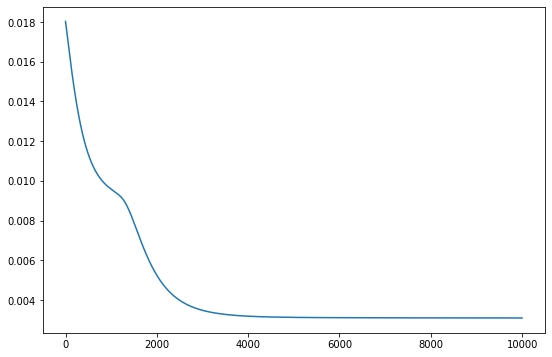

In [24]:
E = np.zeros((trajectory.shape[0]))

for k in range(E.size):
    E[k] =  np.sum(trajectory[k,0:system.n_kmax]*system.DOS_vec*system.E_el_vec)
    
plt.plot(t_vec,E)
plt.show()

[7.86123652e-02 5.52973938e+02 3.13146949e-03]
[0.00233768 0.00063532 0.00011425]


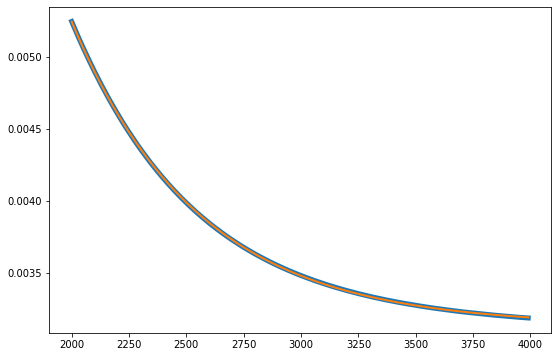

In [27]:
t_fit = t_vec[200:400]
E_fit = E[200:400]

# plt.plot(t_fit,E_fit)
# plt.show()

def fit_exp(t,A,tau,offset):
    return A*np.exp(-t/tau) + offset


from scipy.optimize import curve_fit

popt, pcov = curve_fit(fit_exp, t_fit, E_fit, [0.003,500,0.003])
perr = np.sqrt(np.diag(pcov))

print(popt)
print(perr/popt)


plt.plot(t_fit,E_fit, lw=5)
plt.plot(t_fit, fit_exp(t_fit,*popt), lw=2)
plt.show()